# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [1]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
from scipy import stats
from twelvedata import TDClient

## Annotations begin here:

## Do stock prices follow the log-normal distribution?

Intuitively, it feels like indexes like S&P 500 should have more regular behavior than individual stocks. Let us take a look at the 'SPY' index.

(Note: Using TwelveData rather than yfinance for obtaining data over longer periods of time. Replace "apikey" with personal key before running.)

In [ ]:
# Initialize client - apikey parameter is required
td = TDClient(apikey="apikey")

# Construct the necessary time series
SPY_daily_ts = td.time_series(
    symbol="SPY",
    interval="1day",
    outputsize=5000,
    timezone="America/New_York",
)

# Returns pandas.DataFrame
SPY_daily = SPY_daily_ts.as_pandas()

#Function to get log_returns from any stock df
def get_log_returns_df(StockDataFrame):
    return np.log(StockDataFrame['close']/StockDataFrame['close'].shift(1)).dropna()

SPY_daily_log = get_log_returns_df(SPY_daily)

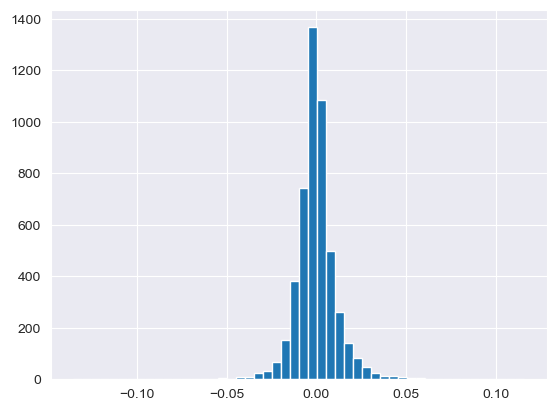

In [3]:
plt.hist(SPY_daily_log, bins = 50)
plt.show()

Looks "normal", but looks can be deceiving. 

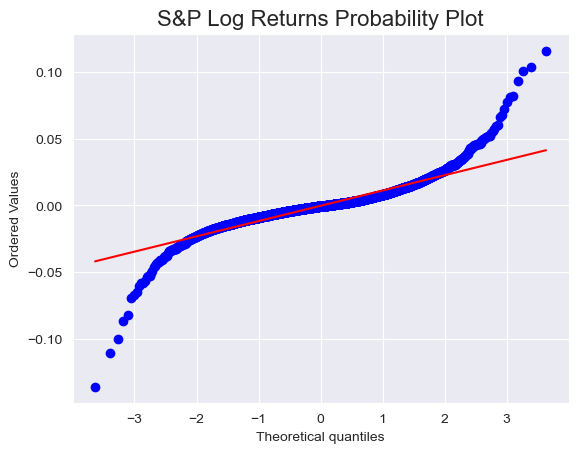

In [4]:
stats.probplot(SPY_daily_log, dist="norm", plot=plt)
plt.title("S&P Log Returns Probability Plot", fontsize=16)
plt.grid(True)

In [5]:
stats.normaltest(SPY_daily_log)

NormaltestResult(statistic=1124.7354142733668, pvalue=5.845315942091487e-245)

**Extremely** small p-value, providing conclusive evidence that the distribution is not normal. 

We can check if removing outliers improves this result. Although, it is not advisable to do so. Normality testing is prone to false positives, and altering the data by removing outliers misses the key behaviours on big trading days.

In [6]:
#Normality testing on a random subset of 500 days from the dataset with 60 outliers excluded.
stats.normaltest(np.sort(SPY_daily_log[1500:2000])[30:-30])

NormaltestResult(statistic=3.9486993126161773, pvalue=0.13885158413775076)

We see that we get strong evidence of log-normal behavior upon rejecting 20% of the outliers in the data. 

### Here we arrive at the first conclusion. Over large periods of time, stock movements do *not* follow log-normal distribution. 

However, what if we look at smaller intervals of time by splitting up the df into chunks? Perhaps log-normality can appear?

In [7]:
# Function to split dataframe into chunks of constant chunk size (and not any smaller)
def split_dataframe(df, chunk_size):
    result = [df.iloc[i:i+chunk_size] for i in range(0, len(df) - chunk_size, chunk_size)]
    result.append(df.iloc[(len(df)-chunk_size):len(df)])
    return result

Consider a 40-day trading window

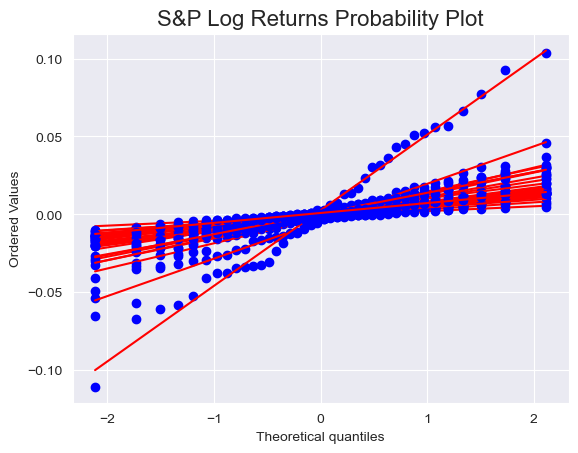

In [8]:
SPY_daily_log_splits = split_dataframe(SPY_daily_log,40)
for i in range(0, len(SPY_daily_log_splits),4):
    stats.probplot(SPY_daily_log_splits[i], dist="norm", plot=plt)
plt.title("S&P Log Returns Probability Plot", fontsize=16)
plt.grid(True)

**Voila!** Most of the chunks are normally distributed, with few outliers. 

Let us investigate the log-normality of SPY index as a function of the time window in consideration (in days).
We define a measure `percent_normal` which considers all trading windows of size `n_days` from the past 5000 days, and measures for what percentage of the chunks we can **not** reject normality (p-value > 0.05). 

In [9]:
def calculate_percent_normal(log_returns_df, n_days, shapiro=False):
    percent_normal = []
    daily_log_splits = split_dataframe(log_returns_df,n_days)
    normal_or_not =[]
    for split_df in daily_log_splits:
        if shapiro==False:
            normal_or_not.append(stats.normaltest(split_df).pvalue > 0.05)
        else:
            normal_or_not.append(stats.shapiro(split_df).pvalue > 0.05)
    #Garbage collection because I have a garbage laptop
    del(daily_log_splits)
    percent_normal.append(100*np.sum(normal_or_not)/len(normal_or_not))
    return percent_normal

SPY_percent_normals = [calculate_percent_normal(SPY_daily_log, n_days) for n_days in range(21, 500, 5)]

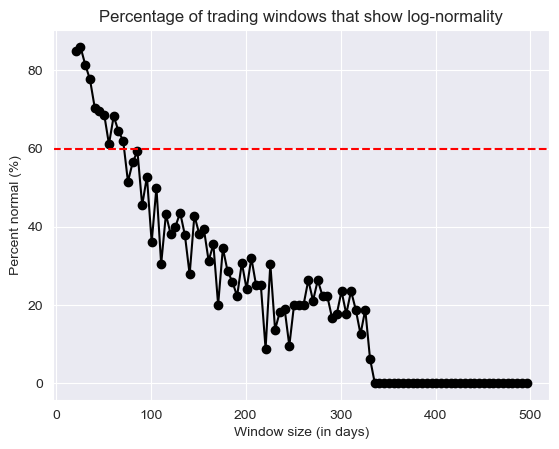

In [10]:
plt.plot(range(21,500,5), SPY_percent_normals, marker = 'o', color='black')
plt.axhline(y=60, color='red', linestyle='dashed')
plt.xlabel('Window size (in days)')
plt.ylabel('Percent normal (%)')
plt.title('Percentage of trading windows that show log-normality')
plt.show()


Thus, we have the clear evidence that for trading windows of size ~50 days or smaller, there is over a 60% chance that the behavior is log-normal. However, as we saw from the probability plots earlier, this does not mean that the volatilities are constant for all the windows. Let us visualize the volatilities calculated over a typical window size that should exhibit log-normal behavior, ~35 days.

SPY's median volatility over 35-day windows for the last 5000 days is  0.13


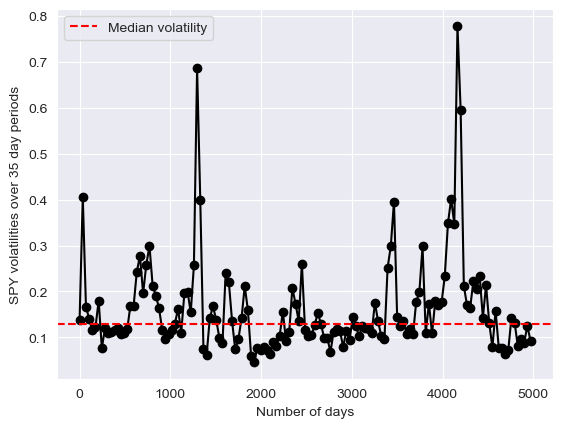

In [11]:
SPY_daily_log_splits = split_dataframe(SPY_daily_log, 35)
volatilities = [np.std(SPY_daily_log_splits[i])*np.sqrt(252) for i in range(len(SPY_daily_log_splits))]
plt.plot(range(0,len(volatilities)*35, 35), volatilities, color='black', marker='o')
print("SPY's median volatility over 35-day windows for the last 5000 days is ", round(np.median(volatilities),2))
plt.axhline(y = np.median(volatilities), color='red', linestyle='dashed', label='Median volatility')
plt.ylabel('SPY volatilities over 35 day periods')
plt.xlabel('Number of days')
plt.legend()
plt.show()

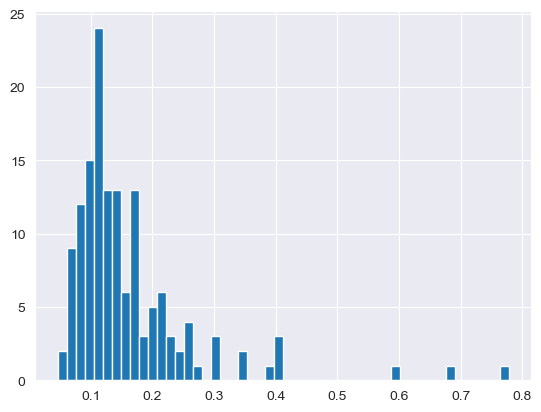

In [12]:
plt.hist(volatilities, bins = 50)
plt.show()

My working hypothesis is that the above conclusion stands for most companies, we expect to see log-normal behavior in the 30-40 day range and not for longer periods of time. This turns out to be even true for famously volatile cryptocurrencies:

In [13]:
ticker = 'ETH/BTC'

# Construct the necessary time series
daily_ts = td.time_series(
    symbol=ticker,
    interval="1day",
    outputsize=5000,
    exchange="Huobi",
    timezone="America/New_York",
)

# Returns pandas.DataFrame
custom_daily = daily_ts.as_pandas()


custom_daily_log = get_log_returns_df(custom_daily)
custom_percent_normals = [calculate_percent_normal(custom_daily_log, n_days,shapiro=True) for n_days in range(21, 500, 5)]

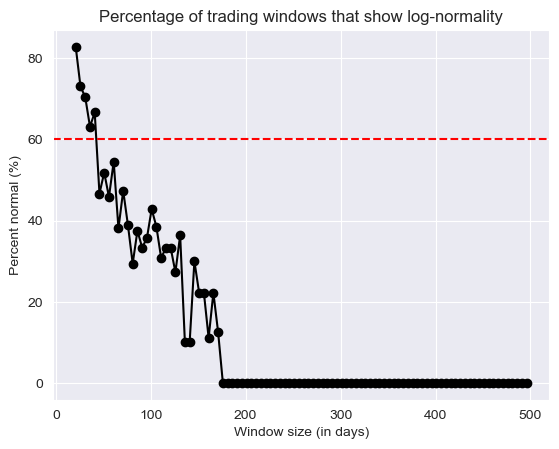

In [14]:
plt.plot(range(21,500,5), custom_percent_normals, marker = 'o', color='black')
plt.axhline(y=60, color='red', linestyle='dashed')
plt.xlabel('Window size (in days)')
plt.ylabel('Percent normal (%)')
plt.title('Percentage of trading windows that show log-normality')
plt.show()
